## Hosting a pre-trained Object Detection model with Chainer

In this notebook, we will demonstrate how to host a pre-trained Chainer model on Amazon SageMaker. We'll send images to a model that identifies objects in an image, and draws bounding boxes around those objects.

For more on the Chainer container, please visit the sagemaker-chainer-containers repository and the sagemaker-python-sdk repository:

* https://github.com/aws/sagemaker-chainer-containers
* https://github.com/aws/sagemaker-python-sdk

In [1]:
# Setup
from sagemaker import get_execution_role
import sagemaker

sagemaker_session = sagemaker.Session()

# This role retrieves the SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

## Uploading the Model Weights

We download model weights from a model that has already been trained, create a compressed tarball from it, and upload it to S3. The Chainer container will download and load this model.

In [2]:
import os
import shutil
import tarfile
import urllib.request

# Download the model weights.
try:
    url = 'https://github.com/yuyu2172/share-weights/releases/download/0.0.3/ssd300_voc0712_2017_06_06.npz'
    urllib.request.urlretrieve (url, '/tmp/ssd_model.npz')

# Tar and compress the model.
    with tarfile.open('/tmp/model.tar.gz', "w:gz") as tar:
         tar.add('/tmp/ssd_model.npz', arcname='ssd_model.npz')

# Upload the model. The `ChainerModel` will use `uploaded_data` to download this model.

    uploaded_model = sagemaker_session.upload_data(path='/tmp/model.tar.gz', 
                                                   key_prefix='notebook/chainercv_ssd')
finally:
    os.remove('/tmp/ssd_model.npz')
    os.remove('/tmp/model.tar.gz')

We will run the `chainercv_ssd.py` script below on SageMaker. This script contains two functions which are used to load the model and predict with the model.

The function hooks for hosting and inference recognized by the container are listed below:


### Hosting and Inference

* **`model_fn(model_dir)`**: This function is invoked to load model artifacts from those written into `model_dir` during training.
* `input_fn(input_data, content_type)`: This function is invoked to deserialize prediction data when a prediction request is made. The return value is passed to predict_fn. `input_fn` accepts two arguments: `input_data`, which is the serialized input data in the body of the prediction request, and `content_type`, the MIME type of the data
  
  
* `predict_fn(input_data, model)`: This function accepts the return value of `input_fn` (as `input_data`) and the return value of `model_fn`, `model`, and returns inferences obtained from the model
  
  
* `output_fn(prediction, accept)`: This function is invoked to serialize the return value from `predict_fn`, passed in via `prediction`, back to the SageMaker client in response to prediction requests


This script implements `model_fn`, and `predict_fn`, but relies on the default `input_fn` and `output_fn`.

For more on implementing these functions, see the documentation at https://github.com/aws/sagemaker-python-sdk.

For more on the functions provided by the Chainer container, see https://github.com/aws/sagemaker-chainer-containers

In [3]:
!cat chainercv_ssd.py

import os

import chainer
import numpy as np

from chainercv.datasets import voc_bbox_label_names
from chainercv.links import SSD300


def model_fn(model_dir):
    """
    This function is called by the Chainer container during hosting when running on SageMaker with
    values populated by the hosting environment.

    Args:
        model_dir (str): path to the directory containing the saved model artifacts

    Returns:
        a loaded Chainer model

    For more on `model_fn` and `save`, please visit the sagemaker-python-sdk repository:
    https://github.com/aws/sagemaker-python-sdk

    For more on the Chainer container, please visit the sagemaker-chainer-containers repository:
    https://github.com/aws/sagemaker-chainer-containers
    """

    # Loads a pretrained SSD model.
    path = os.path.join(model_dir, 'ssd_model.npz')
    model = SSD300(n_fg_class=len(voc_bbox_label_names), pretrained_model=path)
    # If the endpoint instance has GPUs, copy the model to the GPU:
    if 

## Hosting the Model

We construct an instance of `ChainerModel`, passing in S3 URL to the uploaded model to `model_data` and the script to `entry_point`. We'll host on a single `ml.m4.xlarge`.

In [4]:
from sagemaker.chainer.model import ChainerModel
from sagemaker.utils import sagemaker_timestamp

model = ChainerModel(model_data=uploaded_model, role=role, entry_point='chainercv_ssd.py')

endpoint_name = 'chainer-ssd-{}'.format(sagemaker_timestamp())

predictor = model.deploy(instance_type='ml.m4.xlarge', initial_instance_count=1, endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: sagemaker-chainer-2018-05-18-23-00-57-127
INFO:sagemaker:Creating endpoint with name chainer-ssd-2018-05-18-23-00-56-085


--------------------------------------------------!

## Making Predictions with the Hosted Model

Our pre-trained model is now hosted on SageMaker and loaded in the instance. We can use the `predictor` to obtain predictions from our hosted model.

First, let's examine an image that we'd like to detect objects for.

In [5]:
import chainercv
import numpy as np
from matplotlib import pyplot as plot

image = chainercv.utils.read_image('images/dog.jpg', color=True)
image = np.ascontiguousarray(image, dtype=np.uint8)

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


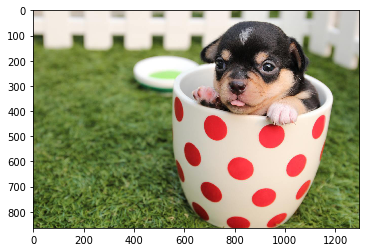

In [6]:
from chainercv.visualizations.vis_image import vis_image
vis_image(image)

Now we obtain predictions. Our model can accept an image (as a NumPy array) and return labels corresponding to objects in the image, scores corresponding to the confidence of those labels, and bounding boxes around those objects.

We pass in the image as a numpy array to `predictor.predict`, and `predict_fn` will be invoked with the arrays we send. We retrieve the bounding boxes, labels, and scores the model predicts given the image.

In [7]:
bbox, label, score = predictor.predict(image)
print('bounding box: {}\nlabel: {}\nscore: {}'.format(bbox, label, score))

bounding box: [list([50.0352783203125, 609.707275390625, 488.0337219238281, 1172.049560546875])]
label: [11]
score: [0.998590350151062]


Let's visualize the bounding boxes predicted by the hosted model

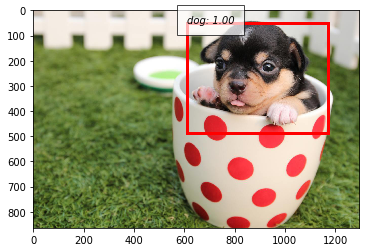

In [8]:
from chainercv.visualizations import vis_bbox
from chainercv.datasets import voc_bbox_label_names
import matplotlib.pyplot as plt
vis_bbox(image, bbox, label, score, label_names=voc_bbox_label_names)
plt.show()

Let's do the same for other images:

In [ ]:
def predict_and_display_images(image_path):
    image = chainercv.utils.read_image(image_path, color=True)
    image = np.ascontiguousarray(image, dtype=np.uint8)

    vis_image(image)
    bbox, label, score = predictor.predict(image)
    vis_bbox(image, bbox, label, score, label_names=voc_bbox_label_names)
    plt.show()

predict_and_display_images('images/dogs.jpg')
predict_and_display_images('images/cats.jpg')
predict_and_display_images('images/cows.jpg')

## Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [ ]:
sagemaker_session.delete_endpoint(predictor.endpoint)